In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
ibm_data = pd.read_csv('/content/IBM_2006-01-01_to_2018-01-01.csv')
msft_data = pd.read_csv('/content/MSFT_2006-01-01_to_2018-01-01.csv')
googl_data = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv')
amzn_data = pd.read_csv('/content/AMZN_2006-01-01_to_2018-01-01.csv')

# Function to preprocess individual stock data
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data[['Close']]

# Preprocess each dataset
ibm = preprocess_data(ibm_data)
msft = preprocess_data(msft_data)
googl = preprocess_data(googl_data)
amzn = preprocess_data(amzn_data)

# Combine the datasets
combined_df = pd.concat([ibm, msft, googl, amzn], axis=1)
combined_df.columns = ['IBM', 'MSFT', 'GOOGL', 'AMZN']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)

# Create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, seq_length, combined_df.shape[1], 1)
X_test = X_test.reshape(-1, seq_length, combined_df.shape[1], 1)
y_train = y_train.reshape(-1, combined_df.shape[1])
y_test = y_test.reshape(-1, combined_df.shape[1])


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape, num_features):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    # Output layer
    c6 = layers.Conv2D(num_features, (1, 1), activation='relu', padding='same')(c5)
    outputs = layers.GlobalAveragePooling2D()(c6)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

input_shape = (seq_length, combined_df.shape[1], 1)
num_features = combined_df.shape[1]
model = build_unet(input_shape, num_features)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 4, 1)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 60, 4, 64)            640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 30, 2, 64)            0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 30, 2, 128)           73856     ['max_pooling2d[0][0]']   

In [3]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
60/60 [==============================] - 12s 42ms/step - loss: 0.1593 - val_loss: nan
Epoch 2/50
60/60 [==============================] - 1s 16ms/step - loss: 0.1330 - val_loss: nan
Epoch 3/50
60/60 [==============================] - 1s 17ms/step - loss: 0.1091 - val_loss: nan
Epoch 4/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0921 - val_loss: nan
Epoch 5/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0803 - val_loss: nan
Epoch 6/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0722 - val_loss: nan
Epoch 7/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0666 - val_loss: nan
Epoch 8/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0627 - val_loss: nan
Epoch 9/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0601 - val_loss: nan
Epoch 10/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0583 - val_loss: nan
Epoch 11/50
60/60 [===================

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


19/19 [==============================] - 1s 22ms/step
RMSE: 189.83462426324198
MAE: 118.23834420036624
R²: -0.0025612415159193547


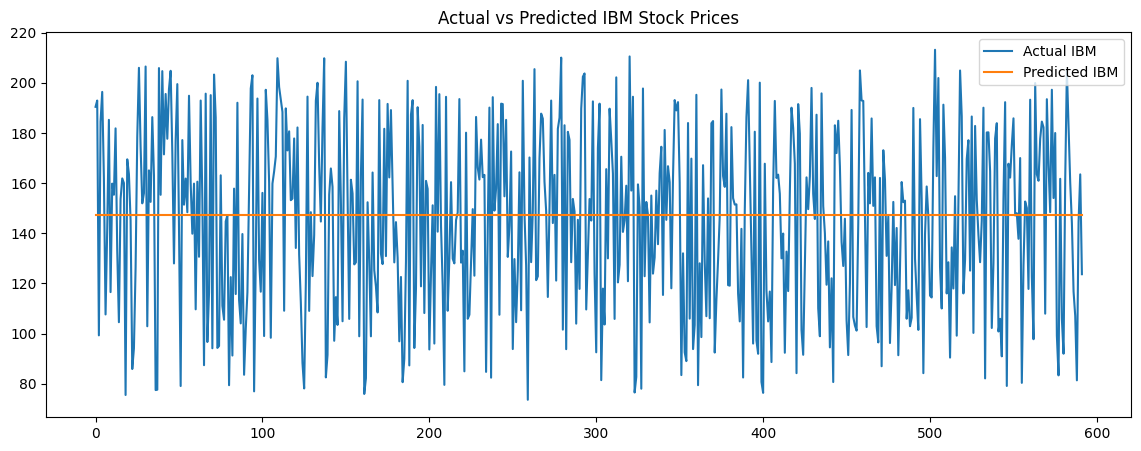

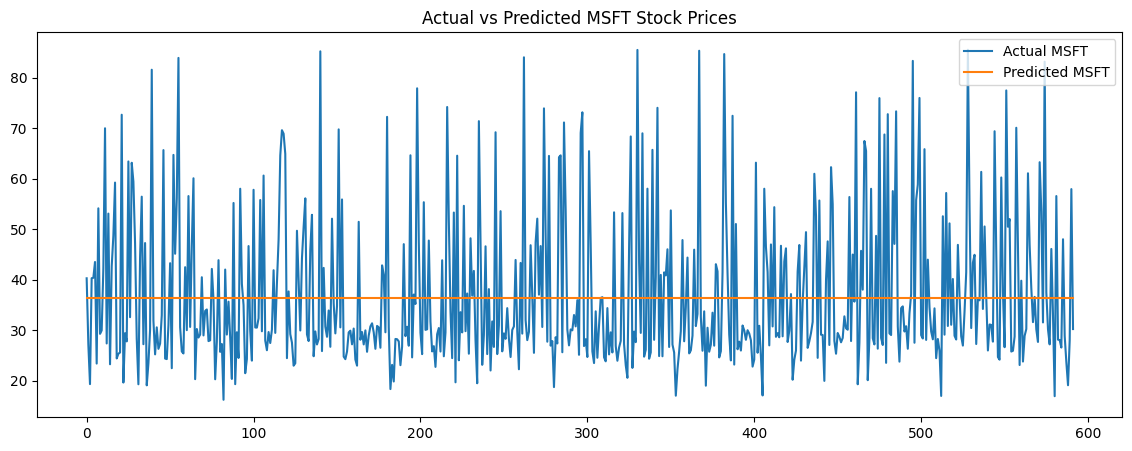

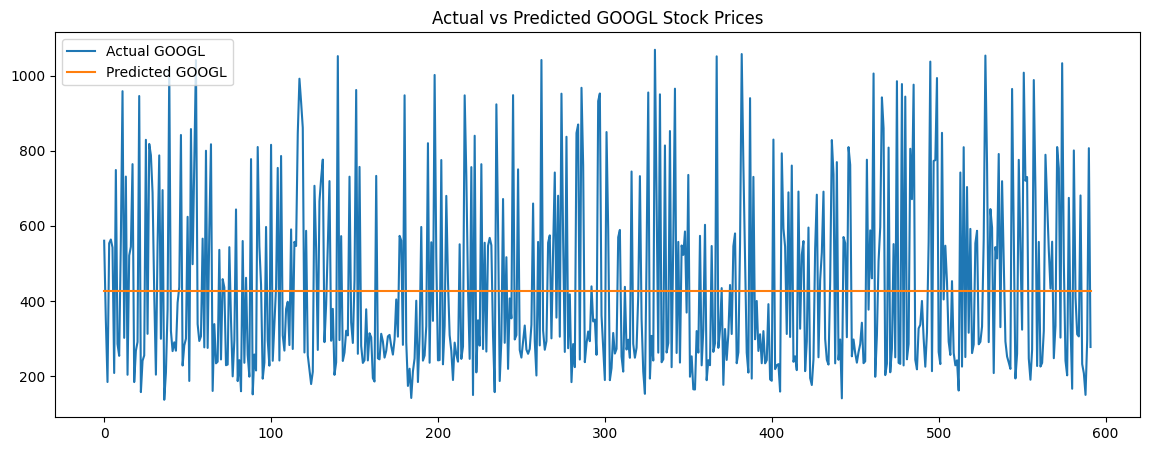

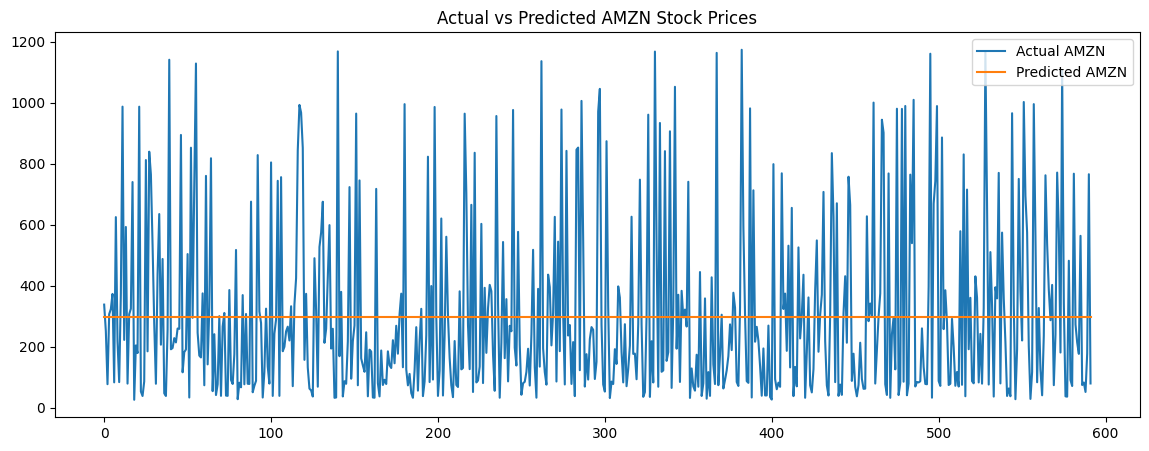

In [5]:
import matplotlib.pyplot as plt

stock_names = ['IBM', 'MSFT', 'GOOGL', 'AMZN']

for i, stock in enumerate(stock_names):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test_rescaled[:, i], label=f'Actual {stock}')
    plt.plot(y_pred_rescaled[:, i], label=f'Predicted {stock}')
    plt.legend()
    plt.title(f'Actual vs Predicted {stock} Stock Prices')
    plt.show()
